In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('project3.ok')

Assignment: Project 3: Movie Classification
OK, version v1.14.20



# Project 3: Movie Classification
Welcome to the third project of data science!  You will build a classifier that guesses whether a movie is romance or action, using only the number of times words appear in the movies's screenplay.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

### Logistics


**Deadline.** This project is due at **11:59pm on Tuesday June 2**. It's **much** better to be early than late, so start working now.

**Checkpoint.** For full credit, you must also **complete Parts 1 and 2 of the project (out of 4) and submit it by 11:59pm on Tuesday May 19**.  You will not have lab time to work on these questions, so I recommend that you start early on each part to stay on track.

**Partners.** You may work with one other partner; this partner **must** be enrolled in the same lab section as you are. Only one of you is required to submit the project. On [okpy.org](http://okpy.org), the person who submits should also designate their partner so that both of you receive credit.

**Rules.** Don't share your code with anybody but your partner. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for exams (and life). If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.**  You are not alone! Come to office hours, post on Canvas, and talk to your classmates.

**Tests.** Passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work!

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Also, please be sure to not re-assign variables throughout the notebook! For example, if you use max_temperature in your answer to one question, do not reassign it later on.

To get started, load `datascience`, `numpy`, `plots`, and `ok`.

In [2]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('project3.ok')
_ = ok.auth(inline=True)

/usr/local/lib/python3.8/site-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.8/site-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
<ipython-input-2-5bc391f7a89f>:8: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be remo

Assignment: Project 3: Movie Classification
OK, version v1.14.20



ERROR  | auth.py:102 | {'error': 'invalid_grant'}



Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: BuWzXgtgsayZkvUiHEXiYDSfMm5zEp
Successfully logged in as A01631920@itesm.mx


# 1. The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [3]:
movies = Table.read_table('movies.csv')
movies.where("Title", "the matrix").select(0, 1, 2, 3, 4, 5, 10, 30, 5005)

Title,Genre,Year,Rating,# Votes,# Words,it,not,fling
the matrix,action,1999,8.7,389480,3792,0.030327,0.00870253,0


The above cell prints a few columns of the row for the action movie *The Matrix*.  The movie contains 3792 words. The word "it" appears 115 times, as it makes up  $\frac{115}{3792} \approx 0.030327$ of the words in the movie. The word "not" appears 33 times, as it makes up $\frac{33}{3792} \approx 0.00870253$ of the words. The word "fling" doesn't appear at all.

This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [4]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('the terminator')

Row(Title='the terminator', Genre='action', Year=1984, Rating=8.1, # Votes=183538, # Words=1849, i=0.040021633, the=0.043807463, to=0.025419145, a=0.024878313, it=0.034613304, and=0.011357491, that=0.016765818999999998, of=0.008653326, your=0.010275825, what=0.009734992, in=0.012979988999999999, me=0.012979988999999999, is=0.007030827, do=0.005949161999999999, thi=0.010275825, dont=0.010275825, he=0.007030827, for=0.008653326, im=0.008653326, know=0.006489995, have=0.0032449970000000003, be=0.010275825, my=0.004326663, we=0.007030827, not=0.008653326, on=0.007030827, go=0.010275825, no=0.005949161999999999, wa=0.008112493, but=0.004867496, with=0.002163332, are=0.005408329, get=0.008112493, just=0.008112493, like=0.008653326, all=0.001622499, there=0.00757166, about=0.005949161999999999, want=0.004326663, if=0.0032449970000000003, here=0.008112493, out=0.00757166, well=0.001622499, think=0.00378583, they=0.004867496, up=0.005408329, him=0.005408329, can=0.005949161999999999, one=0.0075

For example, the fastest way to find the frequency of "hey" in the movie *The Terminator* is to access the `'hey'` item from its row. Check the original table to see if this worked for you!

In [5]:
row_for_title('the terminator').item('hey') 

0.000540833

#### Question 1.1
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first six columns.

<!--
BEGIN QUESTION
name: q1_1
-->

In [6]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [7]:
ok.grade("q1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [8]:
print('Words with frequencies:', movies.drop(np.arange(6)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 242


## 1.1. Word Stemming
The columns other than "Title", "Genre", "Year", "Rating", "# Votes" and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [9]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
blame,blamed
blame,blame
blank,blanks
blank,blank
blank,blankness
blanket,blanket
blanket,blankets
blast,blasting
blast,blast
blast,blasted


#### Question 1.1.1
Assign `stemmed_message` to the stemmed version of the word "alternating".

<!--
BEGIN QUESTION
name: q1_1_1
-->

In [10]:
stemmed_message = vocab_table.where(vocab_table.column("Word"), are.equal_to("alternating"))
stemmed_message

Stem,Word
altern,alternating


In [11]:
ok.grade("q1_1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.2
Assign `unstemmed_run` to an array of words in `vocab_table` that have "run" as its stemmed form. 

<!--
BEGIN QUESTION
name: q1_1_2
-->

In [13]:
unstemmed_run = vocab_table.where(vocab_table.column("Stem"), are.equal_to("run")).column("Word")
unstemmed_run

array(['runs', 'running', 'run', 'runned', 'runnings'], dtype='<U17')

In [14]:
ok.grade("q1_1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.3
Which word in `vocab_table` was shortened the most by this stemming process? Assign `most_shortened` to the word. If there are multiple words, use the word whose first letter is latest in the alphabet (so if your options are albatross or batman, you should pick batman). 

It's an example of how heuristic stemming can collapse two unrelated words into the same stem (which is bad, but happens a lot in practice anyway).

<!--
BEGIN QUESTION
name: q1_1_3
-->

In [17]:
# In my solution, I found it useful to first make an array
# containing the number of characters that was
# chopped off of each word in vocab_table, but you don't have
# to do that.
shortened = vocab_table.apply(len, "Word") - vocab_table.apply(len, "Stem")

most_shortened = vocab_table.with_column("Short", shortened)\
                            .where("Short", are.equal_to(max(shortened)))\
                            .sort("Word", descending = True)\
                            .column(1)\
                            .item(0)

# This will display your answer and its shortened form.
vocab_table.where('Word', most_shortened)

Stem,Word
respons,responsibilities


In [18]:
ok.grade("q1_1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 1.2. Splitting the dataset
We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [19]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  205 ; Test:  37


#### Question 1.2.1
Draw a horizontal bar chart with two bars that show the proportion of Action movies in each dataset.  Complete the function `action_proportion` first; it should help you create the bar chart.

<!--
BEGIN QUESTION
name: q1_2_1
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

Datasets | Action Proportion
Train    | 114
Test     | 21


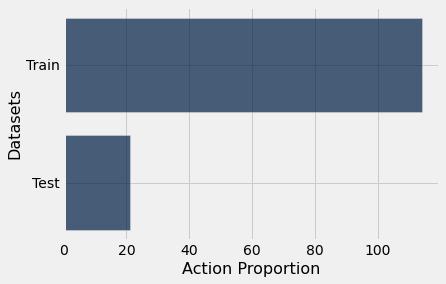

In [21]:
def action_proportion(table):
    # Return the proportion of movies in a table that have the Action genre.
    return np.count_nonzero(table.column("Genre") == "action")

# My solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work

barh_table = Table().with_columns(
                        "Datasets", make_array("Train", "Test"),
                        "Action Proportion", make_array(action_proportion(train_movies), action_proportion(test_movies))            
)

print(barh_table)
barh_table.barh("Datasets", "Action Proportion")


# 2. K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: romance and action.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "money" and "feel" in the movie.  Taking the movie "Batman Returns" (in the test set), 0.000502 of its words are "money" and 0.004016 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.

For example, in the movie *Titanic* (in the training set), 0.0009768 of all the words in the movie are "money" and 0.0017094 are "feel".  Its distance from *Batman Returns* on this 2-word feature set is $\sqrt{(0.000502 - 0.0009768)^2 + (0.004016 - 0.0017094)^2} \approx 0.00235496$.  (If we included more or different features, the distance could be different.)

A third movie, *The Avengers* (in the training set), is 0 "money" and 0.001115 "feel".

The function below creates a plot to display the "money" and "feel" features of a test movie and some training movies. As you can see in the result, *Batman Returns* is more similar to *Titanic* than to *The Avengers* based on these features. However, we know that *Batman Returns* and *The Avengers* are both action movies, so intuitively we'd expect them to be more similar. Unfortunately, that isn't always the case. We'll discuss this more later.

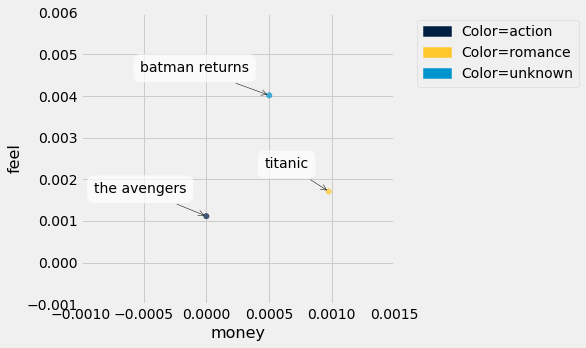

In [22]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=30)
    
training = ["titanic", "the avengers"] 
plot_with_two_features("batman returns", training, "money", "feel")
plots.axis([-0.001, 0.0015, -0.001, 0.006]);

#### Question 2.1.1

Compute the distance between the two action movies, *Batman Returns* and *The Avengers*, using the `money` and `feel` features only.  Assign it the name `action_distance`.

**Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint*: Remember the function `row_for_title`, redefined for you below.

<!--
BEGIN QUESTION
name: q1_2_1
-->

In [23]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

batman = row_for_title("batman returns") 
avengers = row_for_title("the avengers") 
action_distance = ((batman.item("money")-(avengers.item("money")))**2 + (batman.item("feel") - avengers.item("feel"))**2)**0.5
action_distance

0.0029437356216700243

In [24]:
ok.grade("q1_2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Below, we've added a third training movie, *The Terminator*. Before, the point closest to *Batman Returns* was *Titanic*, a romance movie. However, now the closest point is *The Terminator*, an action movie.

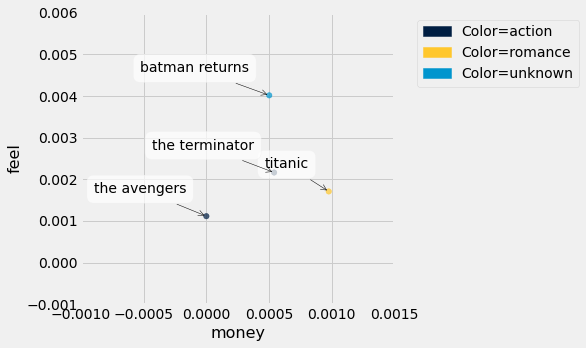

In [25]:
training = ["the avengers", "titanic", "the terminator"] 
plot_with_two_features("batman returns", training, "money", "feel") 
plots.axis([-0.001, 0.0015, -0.001, 0.006]);

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Batman Returns* is closer to *The Terminator* than *The Avengers*. 

<!--
BEGIN QUESTION
name: q2_1_2
-->

In [27]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return ((row0.item(x_feature) - row1.item(x_feature))**2 + (row0.item(y_feature) - row1.item(y_feature))**2)**0.5

for movie in make_array("the terminator", "the avengers"):
    movie_distance = distance_two_features(movie, "batman returns", "money", "feel")
    print(movie, 'distance:\t', movie_distance)

the terminator distance:	 0.0018531387547749904
the avengers distance:	 0.0029437356216700243


In [28]:
ok.grade("q2_1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.3
Define the function `distance_from_batman_returns` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

<!--
BEGIN QUESTION
name: q2_1_3
-->

In [47]:
def distance_from_batman_returns(title):
    """The distance between the given movie and "batman returns", based on the features "money" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features(title, "batman returns", "money", "feel")

In [48]:
ok.grade("q2_1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.4

Using the features `"money" and "feel"`, what are the names and genres of the 7 movies in the **training set** closest to *Batman Returns*?  To answer this question, make a table named `close_movies` containing those 7 movies with columns `"Title"`, `"Genre"`, `"money"`, and `"feel"`, as well as a column called `"distance from batman"` that contains the distance from *Batman Returns*.  The table should be **sorted in ascending order by `distance from batman`**.

<!--
BEGIN QUESTION
name: q2_1_4
-->

In [49]:
# My solution took multiple lines.
mo_fe = train_movies.select("Title", "Genre", "money", "feel")
close_movies = mo_fe.with_column("distance from batman", mo_fe.apply(distance_from_batman_returns, "Title"))\
                                .sort("distance from batman", descending = True).take(np.arange(7))
close_movies

Title,Genre,money,feel,distance from batman
the beach,romance,0.00855746,0,0.00900106
charade,romance,0.00394011,0.000131337,0.00518764
the hustler,romance,0.00538401,0.00253365,0.0051021
birthday girl,romance,0.00447427,0.000894855,0.00505182
reindeer games,action,0.00366159,0.000385431,0.00481295
domino,action,0.00271108,0,0.00458353
15 minutes,action,0.00300501,0.00033389,0.00445235


In [50]:
ok.grade("q2_1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.5
Next, we'll clasify *Batman Returns* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

<!--
BEGIN QUESTION
name: q2_1_5
-->

In [51]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    return table.group(label).sort("count", descending = True).column(label).item(0)

# Calling most_common on your table of 7 nearest neighbors classifies
# "batman returns" as a romance movie, 5 votes to 2. 
most_common('Genre', close_movies)

'romance'

In [52]:
ok.grade("q2_1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q2_1_5 > Suite 1 > Case 2

>>> [most_common('Genre', close_movies.take(range(7-k, 7))) for k in range(1, 8, 2)]
['action', 'action', 'action', 'romance']

# Error: expected
#     ['romance', 'romance', 'romance', 'romance']
# but got
#     ['action', 'action', 'action', 'romance']

Run only this test case with "python3 ok -q q2_1_5 --suite 1 --case 2"
---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 1
[oooook.....] 50.0% passed



Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Batman Returns* as a romance movie (unless you count the bromance between Alfred and Batman). Let's see if we can do better!

## Checkpoint (Due May 19)
#### Congratulations, you have reached the first checkpoint! Run the submit cell below to generate the checkpoint submission.
To get full credit for this checkpoint, you must pass all the public autograder tests above this cell.

In [53]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'project3.ipynb'.
Submit... 100% complete
Submission successful for user: A01631920@itesm.mx
URL: https://okpy.org/tec/tc2031/sp20/project3/submissions/002MvL



# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.1
Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length. 

Next, use the function you just defined to compute the distance between the first and second movie in the training set *using all of the features*.  (Remember that the first six columns of your tables are not features.)

**Note:** To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

<!--
BEGIN QUESTION
name: q3_1
-->

In [ ]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    ...

distance_first_to_second = ...
distance_first_to_second

In [ ]:
ok.grade("q3_1");

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

#### Question 3.0.1
In this question, we will help you get started on selecting more effective features for distinguishing romance from action movies. The plot below (generated for you) shows the average number of times each word occurs in a romance movie on the horizontal axis and the average number of times it occurs in an action movie on the vertical axis. 

![alt text](word_plot.png "Title")

The following questions ask you to interpret the plot above. For each question, select one of the following choices and assign its number to the provided name.
    1. The word is uncommon in both action and romance movies
    2. The word is common in action movies and uncommon in romance movies
    3. The word is uncommon in action movies and common in romance movies
    4. The word is common in both action and romance movies
    5. It is not possible to say from the plot 
    
What properties does a word in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

<!--
BEGIN QUESTION
name: q3_0_1
-->

In [ ]:
bottom_left = ...

In [ ]:
ok.grade("q3_0_1");

**Question 3.0.2**

What properties does a word in the bottom right corner have?

<!--
BEGIN QUESTION
name: q3_0_2
-->

In [ ]:
bottom_right = ...

In [ ]:
ok.grade("q3_0_2");

**Question 3.0.3**

What properties does a word in the top right corner have?

<!--
BEGIN QUESTION
name: q3_0_3
-->

In [ ]:
top_right = ...

In [ ]:
ok.grade("q3_0_3");

**Question 3.0.4**

What properties does a word in the top left corner have?

<!--
BEGIN QUESTION
name: q3_0_4
-->

In [ ]:
top_left = ...

In [ ]:
ok.grade("q3_0_4");

**Question 3.0.5**

If we see a movie with a lot of words that are common for action movies but uncommon for romance movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the number corresponding to your answer:
    1. It is an action movie.
    2. It is a romance movie.
    
<!--
BEGIN QUESTION
name: q3_0_5
-->

In [ ]:
movie_genre_guess = ...

In [ ]:
ok.grade("q3_0_5");

#### Question 3.1.1
Using the plot above, choose 20 common words that you think might let you distinguish between romance and action movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the 20 most frequent, though... you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  

<!--
BEGIN QUESTION
name: q3_1_1
-->

In [ ]:
# Set my_20_features to an array of 20 features (strings that are column labels)

my_20_features = ...

# Select the 20 features of interest from both the train and test sets
train_20 = train_movies.select(my_20_features)
test_20 = test_movies.select(my_20_features)

In [ ]:
ok.grade("q3_1_1");

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

#### Question 3.1.2
In two sentences or less, describe how you selected your features.

<!--
BEGIN QUESTION
name: q3_1_2
manual: True
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [ ]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_20.take(0).show()

As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using the 20 selected features) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [ ]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_20.row(0)).
      train_table: A table of features (for example, the whole
        table train_20)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Question 3.1.3
Use the `fast_distances` function provided above to compute the distance from the first movie in the test set to all the movies in the training set, **using your set of 20 features**.  Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in increasing order by distance to the first test movie**.

<!--
BEGIN QUESTION
name: q3_1_3
-->

In [ ]:
# MY solution took multiple lines of code.
genre_and_distances = ...
genre_and_distances

In [ ]:
ok.grade("q3_1_3");

#### Question 3.1.4
Now compute the 5-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 5 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

<!--
BEGIN QUESTION
name: q3_1_4
-->

In [ ]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = ...

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = ...

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

In [ ]:
ok.grade("q3_1_4");

## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_20.row(0)`).
* A table with a column for each feature (e.g., `train_20`).
* An array of classes (e.g. the labels "romance" or "action") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'romance'` or the string `'action'`).

<!--
BEGIN QUESTION
name: q3_2_1
-->

In [ ]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = ...
    ...

In [ ]:
ok.grade("q3_2_1");

#### Question 3.2.2

Assign `king_kong_genre` to the genre predicted by your classifier for the movie "king kong" in the test set, using **11 neighbors** and using your 20 features.

<!--
BEGIN QUESTION
name: q3_2_2
-->

In [ ]:
# My solution first defined a row called king_kong_features.
king_kong_features = ...
king_kong_genre = ...
king_kong_genre

In [ ]:
ok.grade("q3_2_2");

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 11-nearest neighbors algorithm with `train_20` as its training set.

<!--
BEGIN QUESTION
name: q3_2_3
-->

In [ ]:
def classify_feature_row(row):
    ...

# When you're done, this should produce 'Romance' or 'Action'.
classify_feature_row(test_20.row(0))

In [ ]:
ok.grade("q3_2_3");

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  **Then**, compute the proportion of correct classifications. 

<!--
BEGIN QUESTION
name: q3_3_1
-->

In [ ]:
test_guesses = ...
proportion_correct = ...
proportion_correct

In [ ]:
ok.grade("q3_3_1");

**Question 3.3.2.** An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column should contain `True` or `False` depending on whether or not the movie was classified correctly.

<!--
BEGIN QUESTION
name: q3_3_2
-->

In [ ]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
test_movie_correctness = ...
test_movie_correctness.sort('Was correct', descending = True).show(5)

In [ ]:
ok.grade("q3_3_2");

**Question 3.3.3.** Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia.

<!--
BEGIN QUESTION
name: q3_3_3
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

#### Question 4.1
Develop a classifier with better test-set accuracy than `classify_feature_row`.  Your new function should have the same arguments as `classify_feature_row` and return a classification.  Name it `another_classifier`. Then, check your accuracy using code from earlier.

You can use more or different features, or you can try different values of `k`. (Of course, you still have to use `train_movies` as your training set!) 

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

In [ ]:
# To start you off, here's a list of possibly-useful features
# Feel free to add or change this array to improve your classifier
new_features = make_array("come", "do", "have", "heart", "make", "never", "now", "wanna", "with", "yo")

train_new = train_movies.select(new_features)
test_new = test_movies.select(new_features)

def another_classifier(row):
    return ...

**Question 4.2** 

Do you see a pattern in the mistakes your new classifier makes? What about in the improvement from your first classifier to the second one? Describe in two sentences or less.

**Hint:** You may not be able to see a pattern.

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

**Question 4.3**

Briefly describe what you tried to improve your classifier. 

<!--
BEGIN QUESTION
name: q4_3
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

Congratulations: you're done with the required portion of the project! Time to submit.

In [ ]:
_ = ok.submit()

## 5. Other Classification Methods (OPTIONAL)

**Note**: Everything below is **OPTIONAL**. Please only work on this part after you have finished and submitted the project. If you create new cells below, do NOT reassign variables defined in previous parts of the project.

Now that you've finished your k-NN classifier, you might be wondering what else you could do to improve your accuracy on the test set. Classification is one of many machine learning tasks, and there are plenty of other classification algorithms! If you feel so inclined, we encourage you to try any methods you feel might help improve your classifier. 

We've compiled a list of blog posts with some more information about classification and machine learning. Create as many cells as you'd like below--you can use them to import new modules or implement new algorithms. 

Blog posts: 

* [Classification algorithms/methods](https://medium.com/@sifium/machine-learning-types-of-classification-9497bd4f2e14)
* [Train/test split and cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [More information about k-nearest neighbors](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
* [Overfitting](https://elitedatascience.com/overfitting-in-machine-learning)

There's a lot to think about, so I encourage you to find more information on your own!

Modules to think about using:

* [Scikit-learn tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)
* [TensorFlow information](https://www.tensorflow.org/tutorials/)

...and many more!

In [ ]:
...